# Neccessary Imports

In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from google.colab import output
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from google.colab import files
from torch.utils.data import DataLoader, TensorDataset

# GPU Configuration

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: Tesla T4


# Upload Images

In [3]:
train_folder_path = '/content/trainset'
validation_folder_path = '/content/validationset'
test_folder_path = '/content/testset'

#create trainset folder if one doesn't exist
if not os.path.exists(train_folder_path):
    os.makedirs(train_folder_path)
    print(f"Directory '{train_folder_path}' created.")

#upload files into trainset
print("Upload Trainset")
uploaded_trainset = files.upload()
for filename, file_content in uploaded_trainset.items():
    file_path = os.path.join(train_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
output.clear()
print("Trainset successfully uploaded")
# Delete the files from the root directory
for filename in uploaded_trainset.keys():
    if os.path.exists(filename):
        os.remove(filename)

#create validationset folder if one doesn't exist
if not os.path.exists(validation_folder_path):
    os.makedirs(validation_folder_path)
    print(f"Directory '{validation_folder_path}' created.")

#upload files into validationset
print("Upload validationset")
uploaded_validationset = files.upload()
for filename, file_content in uploaded_validationset.items():
    file_path = os.path.join(validation_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
output.clear()
print("Validationset successfully uploaded")
# Delete the files from the root directory
for filename in uploaded_validationset.keys():
    if os.path.exists(filename):
        os.remove(filename)

#create testset folder if one doesn't exist
if not os.path.exists(test_folder_path):
    os.makedirs(test_folder_path)
    print(f"Directory '{test_folder_path}' created.")

#upload files into testset
print("Upload Testset")
uploaded_testset = files.upload()
for filename, file_content in uploaded_testset.items():
    file_path = os.path.join(test_folder_path, filename)
    if not os.path.exists(file_path):
        with open(file_path, 'wb') as f:
            f.write(file_content)
# Delete the files from the root directory
for filename in uploaded_testset.keys():
    if os.path.exists(filename):
        os.remove(filename)
output.clear()
print("Testset successfully uploaded")

Testset successfully uploaded


# Preprocess Images

In [4]:
trainset_path = '/content/trainset'
validationset_path = '/content/validationset'
testset_path = '/content/testset'

# Define a transform to apply to the images (adjust the transformations as needed)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_images_from_folder(folder_path):
    image_tensors = []
    labels = []
    for filename in os.listdir(folder_path):
        #Get the labels
        if filename[0]=="p":
            labels.append(1)
        else:
            labels.append(0)
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            # Read the image using OpenCV
            image = cv2.imread(img_path)
            # Convert NumPy array to PIL image
            pil_image = Image.fromarray(image)
            # Apply transformations
            pil_image = preprocess(pil_image)
            image_tensors.append(pil_image)
    return image_tensors, labels

# Load images from trainset and testset folders
trainset_images, trainset_labels = load_images_from_folder(trainset_path)
validationset_images, validationset_labels = load_images_from_folder(validationset_path)
testset_images, testset_labels = load_images_from_folder(testset_path)

# Convert the lists of tensors into a single tensor
trainset_tensor = torch.stack(trainset_images)
validationset_tensor = torch.stack(validationset_images)
testset_tensor = torch.stack(testset_images)

# Print the shape of the resulting tensors
print("Trainset tensor shape:", trainset_tensor.shape)
print("Validationset tensor shape:", validationset_tensor.shape)
print("Testset tensor shape:", testset_tensor.shape)

#set batch size
batch_size = 4 #TODO
# Create DataLoader for training and testing
train_dataset = TensorDataset(trainset_tensor, torch.tensor(trainset_labels))
validation_dataset = TensorDataset(validationset_tensor, torch.tensor(validationset_labels))
test_dataset = TensorDataset(testset_tensor, torch.tensor(testset_labels))
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Trainset tensor shape: torch.Size([516, 3, 224, 224])
Validationset tensor shape: torch.Size([178, 3, 224, 224])
Testset tensor shape: torch.Size([32, 3, 224, 224])


# Load Model

In [5]:
resnet = models.resnet50(pretrained=True)
num_classes = 2
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Fine Tuning

Epoch 0 completed.
Epoch 10 completed.
Epoch 20 completed.


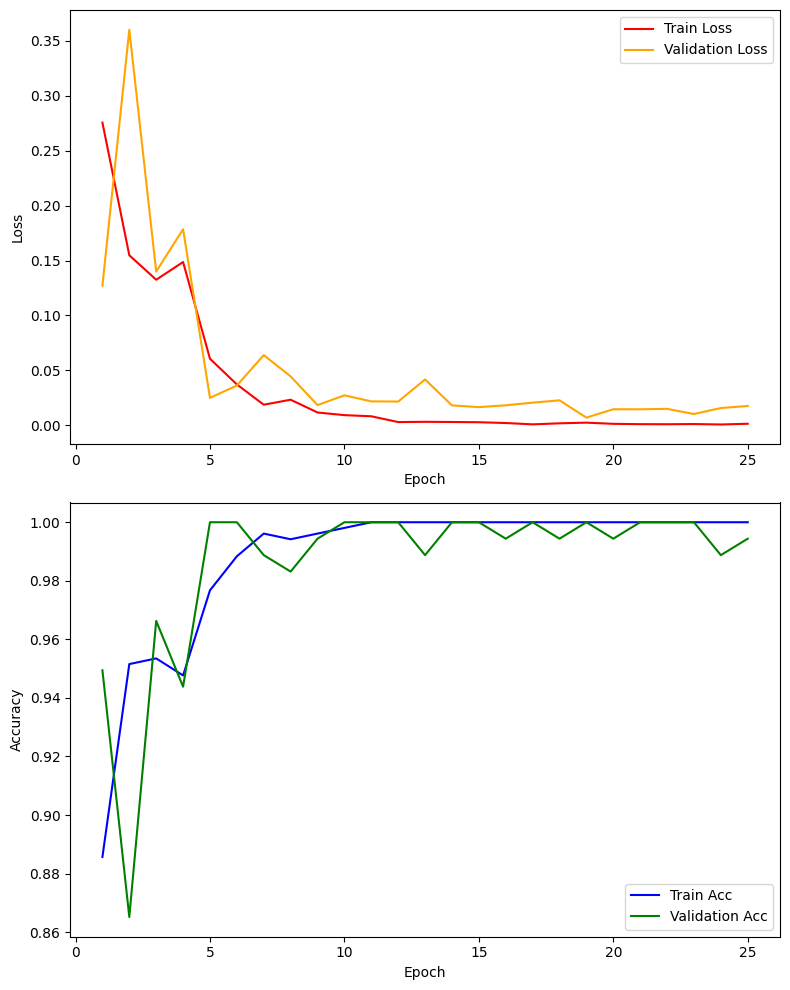

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

#TODO define number of epochs
num_epochs = 25
#arrays for the graphs
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

#training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    #model to training mode
    resnet.train()

    for images, labels in train_loader:
        #move to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        #clear gradients
        optimizer.zero_grad()

        #getting the loss
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        #backward pass and optimization
        loss.backward()
        optimizer.step()

        #get training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    #get the training losses and accuracies to respective arrays
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    #don't affect learning
    with torch.no_grad():
        for images, labels in validation_loader:
            #data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            #getting the loss
            outputs = resnet(images)
            loss = criterion(outputs, labels)

            #compute the validation loss and accuracy
            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            validation_correct += (predicted == labels).sum().item()
            validation_total += labels.size(0)

    #get the valiadtion loss and accuracy
    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = validation_correct / validation_total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    if epoch%10==0:
        print("Epoch "+str(epoch)+" completed.")


#loss graph
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
ax1.plot(range(1, num_epochs+1), train_losses, color="red")
ax1.plot(range(1, num_epochs+1), validation_losses, color="orange")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')
ax1.legend(('Train Loss', 'Validation Loss'))

#accuracy graph
ax2.plot(range(1, num_epochs+1), train_accuracies, color="blue")
ax2.plot(range(1, num_epochs+1), validation_accuracies, color="green")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')
ax2.legend(('Train Acc', 'Validation Acc'))

fig.tight_layout()
plt.show()


PATH = './cnn.pth'
torch.save(resnet.state_dict(), PATH)

In [7]:
#don't affect learning
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0, 1]
    n_class_samples = [0, 1]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 100.0 %


In [9]:
model_path = 'fine_tuned_resnet_50'

# Save the model
torch.save(resnet.state_dict(), model_path)
